In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import tensorflow as tf

from transformers import pipeline, AutoTokenizer

from scipy.special import softmax

from tensorflow.python.ops.numpy_ops import np_config

In [3]:
np_config.enable_numpy_behavior()

## Loading and overview of stored dataset

In [4]:
%store -r DT_rally_speaches_dataset
df = DT_rally_speaches_dataset

In [5]:
df.head()

,Location,Month,Year,filename,content
0,Battle Creek,Dec,2019,BattleCreekDec19_2019.txt,Thank you. Thank you. Thank you to Vice Presid...
1,Bemidji,Sep,2020,BemidjiSep18_2020.txt,There's a lot of people. That's great. Thank y...
2,Charleston,Feb,2020,CharlestonFeb28_2020.txt,Thank you. Thank you. Thank you. All I can say...
3,Charlotte,Mar,2020,CharlotteMar2_2020.txt,"I want to thank you very much. North Carolina,..."
4,Cincinnati,Aug,2019,CincinnatiAug1_2019.txt,Thank you all. Thank you very much. Thank you ...


## Model and tokenizer setup

In [6]:
#checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
checkpoint = 'ProsusAI/finbert'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

## Tokenizing a single rally into chunks

In [87]:
tokens = tokenizer(df.content[0], add_special_tokens=False, return_tensors="tf")
print(tokens)

{'input_ids': <tf.Tensor: shape=(1, 24289), dtype=int32, numpy=array([[4067, 2017, 1012, ..., 4067, 2017, 1012]])>, 'token_type_ids': <tf.Tensor: shape=(1, 24289), dtype=int32, numpy=array([[0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(1, 24289), dtype=int32, numpy=array([[1, 1, 1, ..., 1, 1, 1]])>}


In [88]:
tokens['input_ids'].size, tokens['attention_mask'].size, tokens['input_ids'].size/510, tokens['attention_mask'].size/510

(24289, 24289, 47.62549019607843, 47.62549019607843)

In [89]:
print(f"Number of input id tokens: {tokens['input_ids'].size}")
print(f"Number of attention mask flags: {tokens['attention_mask'].size}")

Number of input id tokens: 24289
Number of attention mask flags: 24289


In [90]:
# Setting up id and mask chunks
chunk_size = 510
id_chunks = np.array_split(tokens['input_ids'][0], math.ceil(tokens['input_ids'].size/chunk_size),axis=0)
mask_chunks = np.array_split(tokens['attention_mask'][0], math.ceil(tokens['attention_mask'].size/chunk_size),axis=0)

In [91]:
print(f"Number of chunks: {tokens['input_ids'].size/chunk_size:.3f}")

Number of chunks: 47.625


In [92]:
id_chunks = [np.concatenate(([101],chunk,[102])) for chunk in id_chunks]
mask_chunks = [np.concatenate(([1],chunk,[1])) for chunk in mask_chunks]

# for chunk in id_chunks:
#     print(chunk)
#     print(len(chunk))

In [93]:
for i in range(len(id_chunks)):
    longest_array = len(max(id_chunks, key=len))
    if len(id_chunks[i]) < longest_array:
        diff = longest_array - len(id_chunks[i])
#         print(diff)
#         print(len(id_chunks[i]))
#         print(longest_array)
        id_chunks[i] = np.concatenate((id_chunks[i],[0]*diff))
        mask_chunks[i] = np.concatenate((mask_chunks[i],[0]*diff))

In [94]:
# id_chunks = [np.concatenate(([101],chunk,[102])) for chunk in id_chunks]

In [95]:
print(len(id_chunks[0]))

509


In [96]:
print(len(mask_chunks[0]))

509


In [97]:
tf_id_chunks = tf.convert_to_tensor(id_chunks)
tf_mask_chunks = tf.convert_to_tensor(mask_chunks)

# for chunk in tf_id_chunks:
#     print(chunk)

In [98]:
input_dict = {
    'input_ids' : tf_id_chunks,
    'attention_mask' : tf_mask_chunks
}
input_dict

{'input_ids': <tf.Tensor: shape=(48, 509), dtype=int32, numpy=
 array([[  101,  4067,  2017, ...,  2079,  2023,   102],
        [  101,  1012,  1045, ...,  2057,   102,     0],
        [  101,  2031,  1037, ...,  1010,   102,     0],
        ...,
        [  101,  2954,  1012, ...,  1998,   102,     0],
        [  101,  1996,  3187, ..., 23523,   102,     0],
        [  101,  4551,  2062, ...,  1012,   102,     0]])>,
 'attention_mask': <tf.Tensor: shape=(48, 509), dtype=int32, numpy=
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 0]])>}

### Running a sentiment analysis on the processed rally

In [99]:
from transformers import TFBertForSequenceClassification #, BertTokenizer

In [100]:
# tokenizer_bert = BertTokenizer.from_pretrained(checkpoint)
model = TFBertForSequenceClassification.from_pretrained(checkpoint)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [101]:
outputs = model(input_dict)

In [102]:
print(outputs.logits.shape)

(48, 3)


In [103]:
print(f"Logits shape -> {outputs.logits.shape}")

Logits shape -> (48, 3)


In [104]:
print(outputs.logits)

tf.Tensor(
[[-0.41827917 -0.3749227  -0.10345925]
 [-0.32495284 -0.46377504 -0.1810839 ]
 [-0.34142518 -0.48254752 -0.05065395]
 [-0.28309512 -0.48541123 -0.03713718]
 [-0.28874367 -0.46956846 -0.02656923]
 [-0.32833868 -0.40382636 -0.06200852]
 [-0.32496262 -0.46296763 -0.06675623]
 [-0.36027142 -0.44003338 -0.11672868]
 [-0.21218525 -0.51511925 -0.05750586]
 [-0.22146258 -0.56243    -0.11830644]
 [-0.25438398 -0.50330275 -0.09778984]
 [-0.22193721 -0.5021694  -0.11440882]
 [-0.2427035  -0.4946494  -0.0789438 ]
 [-0.20876695 -0.5470898  -0.11302897]
 [-0.23260756 -0.5343194  -0.13588414]
 [-0.2512871  -0.43164134 -0.04885272]
 [-0.21895008 -0.48574585 -0.09599911]
 [-0.24466869 -0.48090988 -0.12581503]
 [-0.22298059 -0.5059518  -0.08925903]
 [-0.28880718 -0.48594922 -0.12944987]
 [-0.2605177  -0.43235713 -0.16773638]
 [-0.279494   -0.46008223 -0.14272244]
 [-0.263717   -0.4271816  -0.07421461]
 [-0.24581556 -0.49935913 -0.10184646]
 [-0.2226723  -0.52962637 -0.1230198 ]
 [-0.195882   

In [105]:
model.config.id2label

{0: 'positive', 1: 'negative', 2: 'neutral'}

In [106]:
predictions = tf.math.softmax(outputs.logits, axis=-1)
print(predictions)

tf.Tensor(
[[0.29288384 0.30586156 0.40125456]
 [0.3305659  0.28771886 0.38171527]
 [0.3119306  0.27087525 0.41719425]
 [0.3230305  0.2638632  0.41310623]
 [0.31904697 0.26627073 0.41468233]
 [0.3093622  0.28686884 0.40376902]
 [0.3158859  0.27516642 0.40894777]
 [0.3125882  0.28862396 0.3987878 ]
 [0.34412372 0.25418624 0.40169   ]
 [0.3546418  0.25217944 0.39317876]
 [0.3390791  0.26436076 0.3965601 ]
 [0.34853762 0.2633579  0.38810447]
 [0.33838448 0.26302177 0.39859366]
 [0.3554373  0.2534144  0.39114833]
 [0.35197547 0.26030385 0.38772058]
 [0.3268664  0.27292505 0.4002086 ]
 [0.3452254  0.2643838  0.39039087]
 [0.3429596  0.27079755 0.38624287]
 [0.3452304  0.26014546 0.39462408]
 [0.3340202  0.2742553  0.3917245 ]
 [0.34021288 0.28649813 0.37328896]
 [0.33541903 0.28000078 0.38458014]
 [0.32702777 0.27771083 0.39526144]
 [0.34119278 0.26478127 0.39402592]
 [0.35205424 0.2590008  0.38894492]
 [0.3564044  0.26242417 0.38117144]
 [0.31062534 0.28498065 0.40439403]
 [0.32247433 0.28

In [107]:
mean = tf.math.reduce_mean(predictions, axis=0, keepdims=False, name=None)
print(mean)

tf.Tensor([0.33341685 0.27329552 0.39328766], shape=(3,), dtype=float32)


## Tokenizing all rallies

In [27]:
# Define the maximum token limit for the BERT model
# chunk_size = 500

In [28]:
def split_text_into_chunks(text, chunk_size):
    # Tokenize the text into subwords
    tokens = tokenizer.tokenize(text)
#     tokens = tokenizer.tokenize(text, add_special_tokens=False, return_tensors="tf")
    current_chunk = []  # Current chunk of tokens
    current_chunk_length = 0  # Current total token count in the chunk
    chunks = []  # List to store the text chunks

    for token in tokens:
        # If adding the current token to the chunk doesn't exceed the token limit
        if len(current_chunk) + len(token) <= chunk_size:  # chunk length pf 510 accounts for the [CLS] and [SEP] tokens
            current_chunk.append(token)
            current_chunk_length += len(token)
        else:
            if len(current_chunk) > 0:
                chunks.append(" ".join(current_chunk))
                current_chunk = []
                current_chunk_length = 0

    # Add the last chunk if it's not empty
    if len(current_chunk) > 0:
        chunks.append(" ".join(current_chunk))

    return chunks

In [29]:
input_ids_list = []
attention_masks_list = []
outputs_list = []

for index, row in df.iterrows():
#     text = row["text"]
    text = row["content"]
    text_chunks = split_text_into_chunks(text, chunk_size)

#     input_ids_list = []
#     attention_mask_list = []

    for chunk in text_chunks:
        encoding = tokenizer.encode_plus(
            chunk,
            add_special_tokens=True,
            max_length=chunk_size,
            padding='max_length',
            truncation=True,
            return_tensors='tf'
        )
        input_ids_list.append(encoding['input_ids'])
        attention_mask_list.append(encoding['attention_mask'])

    input_ids = tf.concat(input_ids_list, axis=0)
    attention_mask = tf.concat(attention_mask_list, axis=0)
    
    input_ids_list.append(input_ids)
    attention_masks_list.append(attention_mask)

    # Run sentiment analysis using the BERT model
    outputs = model([input_ids, attention_mask])
    predictions = outputs.logits
    
    outputs_list.append(outputs)

    # Process predictions as needed
    print(f"Predictions for text {index + 1} shape:", predictions.shape)

Predictions for text 1 shape: (48, 3)
Predictions for text 2 shape: (46, 3)
Predictions for text 3 shape: (25, 3)
Predictions for text 4 shape: (18, 3)
Predictions for text 5 shape: (22, 3)
Predictions for text 6 shape: (32, 3)
Predictions for text 7 shape: (28, 3)
Predictions for text 8 shape: (32, 3)
Predictions for text 9 shape: (45, 3)
Predictions for text 10 shape: (24, 3)
Predictions for text 11 shape: (27, 3)
Predictions for text 12 shape: (29, 3)
Predictions for text 13 shape: (24, 3)
Predictions for text 14 shape: (26, 3)
Predictions for text 15 shape: (37, 3)
Predictions for text 16 shape: (33, 3)
Predictions for text 17 shape: (24, 3)
Predictions for text 18 shape: (25, 3)
Predictions for text 19 shape: (38, 3)
Predictions for text 20 shape: (31, 3)
Predictions for text 21 shape: (39, 3)
Predictions for text 22 shape: (26, 3)
Predictions for text 23 shape: (24, 3)
Predictions for text 24 shape: (17, 3)
Predictions for text 25 shape: (31, 3)
Predictions for text 26 shape: (29

## Looking into the mean values for all rallies

In [71]:
predictions = []
means = []

for output in outputs_list:
    prediction = tf.math.softmax(output.logits, axis=-1)
    predictions.append(prediction)
#     print(prediction)
    
    mean = tf.math.reduce_mean(prediction, axis=0, keepdims=False, name=None)
    means.append(mean)
#     print(mean)

In [86]:
for i in range(len(means)):
    mean = means[i]
    print(f"Rally {i + 1}: Positive -> {mean[0]:.2f} || Negative -> {mean[1]:.2f} || Neutral -> {mean[2]:.2f}")

Rally 1: Positive -> 0.44 || Negative -> 0.24 || Neutral -> 0.32
Rally 2: Positive -> 0.43 || Negative -> 0.25 || Neutral -> 0.31
Rally 3: Positive -> 0.45 || Negative -> 0.25 || Neutral -> 0.30
Rally 4: Positive -> 0.45 || Negative -> 0.25 || Neutral -> 0.30
Rally 5: Positive -> 0.44 || Negative -> 0.25 || Neutral -> 0.31
Rally 6: Positive -> 0.44 || Negative -> 0.25 || Neutral -> 0.31
Rally 7: Positive -> 0.45 || Negative -> 0.24 || Neutral -> 0.31
Rally 8: Positive -> 0.45 || Negative -> 0.25 || Neutral -> 0.30
Rally 9: Positive -> 0.44 || Negative -> 0.26 || Neutral -> 0.30
Rally 10: Positive -> 0.45 || Negative -> 0.25 || Neutral -> 0.30
Rally 11: Positive -> 0.46 || Negative -> 0.25 || Neutral -> 0.29
Rally 12: Positive -> 0.45 || Negative -> 0.24 || Neutral -> 0.31
Rally 13: Positive -> 0.45 || Negative -> 0.25 || Neutral -> 0.30
Rally 14: Positive -> 0.44 || Negative -> 0.24 || Neutral -> 0.32
Rally 15: Positive -> 0.44 || Negative -> 0.25 || Neutral -> 0.31
Rally 16: Positive 

## Plotting chunk scores

In [52]:
# Initialize a list to store sentiment scores for the first class for all texts
sentiment_scores_positive = []
sentiment_scores_negative = []
sentiment_scores_neutral = []

# Loop through the outputs_list
for outputs in outputs_list:
    # Extract sentiment scores for the first class (adjust this based on your model's output structure)
    sentiment_scores_positive.append(outputs.logits[:, 0])
    sentiment_scores_negative.append(outputs.logits[:, 1])
    sentiment_scores_neutral.append(outputs.logits[:, 2])

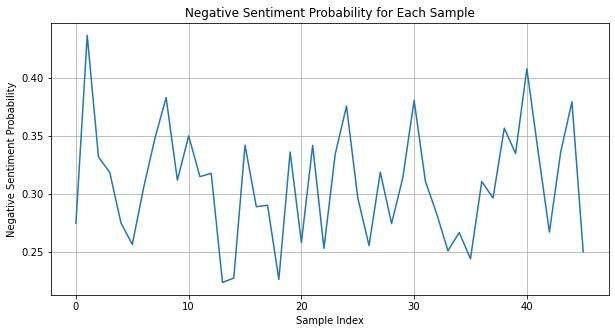

In [54]:
# Create a plot using Matplotlib
plt.figure(figsize=(10, 5))
plt.plot(sentiment_scores_positive[1])
plt.xlabel('Sample Index')
plt.ylabel('Negative Sentiment Probability')
plt.title('Negative Sentiment Probability for Each Sample')
plt.grid(True)
plt.show()

<ipython-input-61-5518f7bcc836>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sentiment_scores_positive_array = np.array(sentiment_scores_positive)


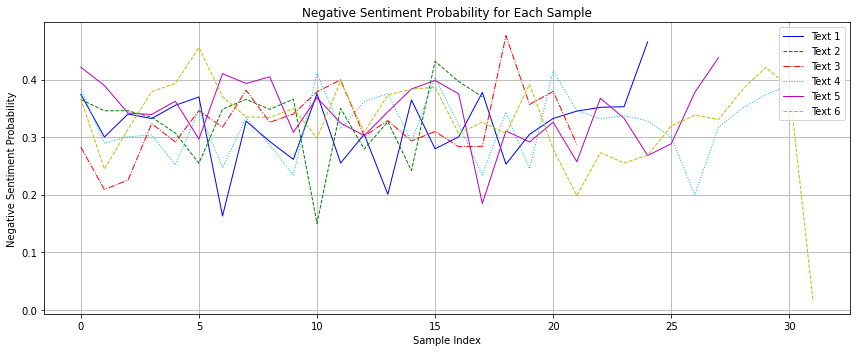

In [61]:
# Convert the list of arrays into a NumPy array for easier manipulation
sentiment_scores_positive_array = np.array(sentiment_scores_positive)

# Picking just a subset of the outputs since all 35 wouldn't be all that readable
sentiment_scores_positive_array = sentiment_scores_positive_array[2:8]

# Create a plot using Matplotlib with improved readability
plt.figure(figsize=(12, 5))

# Define a list of line styles and colors for better differentiation
line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for i in range(sentiment_scores_positive_array.shape[0]):
    # Use different line styles and colors
    line_style = line_styles[i % len(line_styles)]
    color = colors[i % len(colors)]

    # Reduce line width for improved readability
    plt.plot(sentiment_scores_positive_array[i], label=f'Text {i+1}', linestyle=line_style, color=color, linewidth=1)

plt.xlabel('Sample Index')
plt.ylabel('Negative Sentiment Probability')
plt.title('Negative Sentiment Probability for Each Sample')
plt.grid(True)
plt.legend(loc='upper right')

# Adjust chart size
plt.tight_layout()
plt.show()